# Tutorial 3 (JAX): Activation Functions

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial3/Activation_Functions.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial3/Activation_Functions.ipynb)   
**Pre-trained models:**
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/JAX/tutorial3)   
**PyTorch version:**
[![View on RTD](https://img.shields.io/static/v1.svg?logo=readthedocs&label=RTD&message=View%20On%20RTD&color=8CA1AF)](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html)   
**Author:** Phillip Lippe

<div class="alert alert-info">

**Note:** This notebook is written in JAX+Flax. It is a 1-to-1 translation of the original notebook written in PyTorch+PyTorch Lightning with almost identical results. For an introduction to JAX, check out our [Tutorial 2 (JAX): Introduction to JAX+Flax](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html). Further, throughout the notebook, we comment on major differences to the PyTorch version and provide explanations for the major parts of the JAX code. We do not provide speed comparisons for this notebook since they tend to be uninformative for such small networks and potentially bottlenecked by other factors.
    
</div>

In this tutorial, we will take a closer look at (popular) activation functions and investigate their effect on optimization properties in neural networks.
Activation functions are a crucial part of deep learning models as they add the non-linearity to neural networks.
There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we don't.

Before we start, we import our standard libraries and set up basic functions:

In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
from typing import Any, Sequence
import pickle
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

## JAX
import jax
import jax.numpy as jnp
from jax import random

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

C:\Users\197796\AppData\Local\Temp\ipykernel_2692\2159690685.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
c:\Users\197796\Anaconda3\envs\jax\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In contrast to PyTorch, we do not have to set the seed as a global variable since we do not allow for functions with side effects. Instead, we  explicitly define a PRNG key whenever needed for random operations like network initializations.

Additionally, the following cell defines two paths: `DATASET_PATH` and `CHECKPOINT_PATH`. The dataset path is the directory where we will download datasets used in the notebooks. It is recommended to store all datasets from PyTorch in one joined directory to prevent duplicate downloads. The checkpoint path is the directory where we will store trained model weights and additional files. The needed files will be automatically downloaded. In case you are on Google Colab, it is recommended to change the directories to start from the current directory (i.e. remove `../../` for both dataset and checkpoint path).

In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial3_jax"

# Verifying the device that will be used throughout this notebook
print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


The following cell downloads all pretrained models we will use in this notebook. The files are stored on a separate [repository](https://github.com/phlippe/saved_models) to reduce the size of the notebook repository, especially for building the documentation on ReadTheDocs.

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar",
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

## Common activation functions

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `flax.linen` or `jax.nn` package (see the [documentation](https://flax.readthedocs.io/en/latest/flax.linen.html#activation-functions) for an overview).
However, we'll write our own functions here for a better understanding and insights.

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network.
We start with implementing two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh.
Both the sigmoid and tanh activation can be also found as JAX functions (`nn.sigmoid`, `nn.tanh`).
Note that since all modules are essentially functions, you can directly use functions in `nn.Sequential` (e.g. `nn.Sequential([nn.Dense(8), nn.sigmoid, nn.Dense(1)])`.
Still, for a better understanding, we implement them by hand:

In [3]:
##############################

class Sigmoid(nn.Module):

    def __call__(self, x):
        return 1 / (1 + jnp.exp(-x))

##############################

class Tanh(nn.Module):

    def __call__(self, x):
        x_exp, neg_x_exp = jnp.exp(x), jnp.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

##############################

Another popular activation function that has allowed the training of deeper networks, is the Rectified Linear Unit (ReLU).
Despite its simplicity of being a piecewise linear function, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.
Based on this idea, a lot of variations of ReLU have been proposed, of which we will implement the following three: LeakyReLU, ELU, and Swish.
LeakyReLU replaces the zero settings in the negative part with a smaller slope to allow gradients to flow also in this part of the input.
Similarly, ELU replaces the negative part with an exponential decay.
The third, most recently proposed activation function is Swish, which is actually the result of a large experiment with the purpose of finding the "optimal" activation function.
Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. contains a change of sign in the gradient).
This has been shown to prevent dead neurons as in standard ReLU activation, especially for deep networks.
If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941) [1].

Let's implement the four activation functions below:

In [4]:
##############################

class ReLU(nn.Module):

    def __call__(self, x):
        return jnp.maximum(x, 0)

##############################

class LeakyReLU(nn.Module):
    alpha : float = 0.1

    def __call__(self, x):
        return jnp.where(x > 0, x, self.alpha * x)

##############################

class ELU(nn.Module):

    def __call__(self, x):
        return jnp.where(x > 0, x, jnp.exp(x)-1)

##############################

class Swish(nn.Module):

    def __call__(self, x):
        return x * nn.sigmoid(x)

##############################

For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [5]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following.
Since modules are functions in disguise, we can do this by applying JAX's gradient transformation `jax.grad`. However, note that we want to take the gradients for multiple inputs independently and the gradient transformation requires the output of the forward pass to be a single scalar.
We can implement this by simply summing the outputs of the activation function, since a sum distributes the gradients equally to all its inputs.

In [6]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.

    Inputs:
        act_fn - An module or function of the forward pass of the activation function.
        x - 1D input array.
    Output:
        An array with the same size of x containing the gradients of act_fn at x.
    """
    return jax.vmap(jax.grad(act_fn))(x)

Now we can visualize all our activation functions including their gradients:

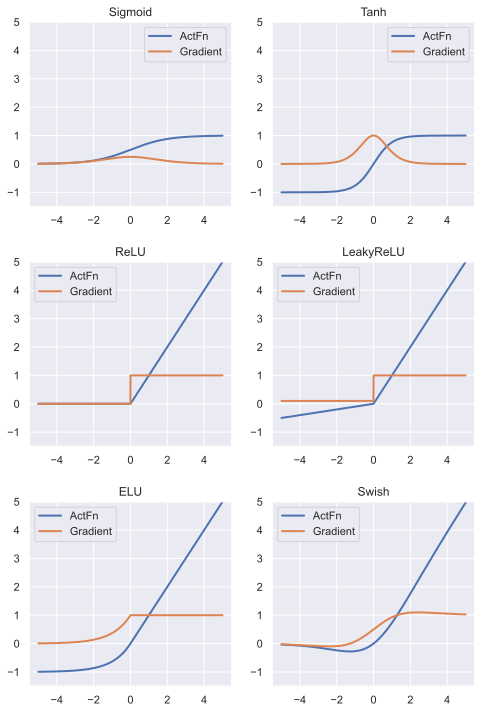

In [7]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    # x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.__class__.__name__)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = np.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

## Analysing the effect of activation functions

After implementing and visualizing the activation functions, we are aiming to gain insights into their effect.
We do this by using a simple neural network trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) and examine various aspects of the model, including the performance and gradient flow.

### Setup

Firstly, let's set up a neural network. The chosen network views the images as 1D tensors and pushes them through a sequence of linear layers and a specified activation function. Feel free to experiment with other network architectures. We explicitly set the initialization for the weights and biases to stay close to the [PyTorch implementation](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html) of the Tutorial. As we will see in [Tutorial 4](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.html), the initialization has a considerable influence on which networks may be trainable with which activation functions.

In [15]:
# To keep the results close to the PyTorch tutorial, we use the same init function as PyTorch
# which is uniform(-1/sqrt(in_features), 1/sqrt(in_features)) - similar to He et al./kaiming
# The default for Flax is lecun_normal (i.e., half the variance of He) and zeros for bias.
init_func = lambda x: (lambda rng, shape, dtype: random.uniform(rng,
                                                                shape=shape,
                                                                minval=-1/np.sqrt(x.shape[1]),
                                                                maxval=1/np.sqrt(x.shape[1]),
                                                                dtype=dtype))

# Network
class BaseNetwork(nn.Module):
    act_fn : nn.Module
    num_classes : int = 10
    hidden_sizes : Sequence = (512, 256, 256, 128)

    @nn.compact
    def __call__(self, x, return_activations=False):
        x = x.reshape(x.shape[0], -1) # Reshape images to a flat vector
        # We collect all activations throughout the network for later visualizations
        # Remember that in jitted functions, unused tensors will anyways be removed.
        activations = []
        for hd in self.hidden_sizes:
            x = nn.Dense(hd,
                         kernel_init=init_func(x),
                         bias_init=init_func(x))(x)
            activations.append(x)
            x = self.act_fn(x)
            activations.append(x)
        x = nn.Dense(self.num_classes,
                     kernel_init=init_func(x),
                     bias_init=init_func(x))(x)
        return x if not return_activations else (x, activations)

We also add functions for loading and saving the model. The hyperparameters are stored in a configuration file (simple json file):

In [8]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, state=None):
    """
    Loads a saved model from disk.

    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        state - (Optional) If given, the parameters are loaded into this training state. Otherwise,
                a new one is created alongside a network architecture.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if state is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
        state = train_state.TrainState(step=0,
                                       params=None,
                                       apply_fn=net.apply,
                                       tx=None,
                                       opt_state=None)
    else:
        net = None
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead load the parameters simply from a pickle file.
    with open(model_file, 'rb') as f:
        params = pickle.load(f)
    state = state.replace(params=params)
    return state, net

def save_model(model, params, model_path, model_name):
    """
    Given a model, we save the parameters and hyperparameters.

    Inputs:
        model - Network object without parameters
        params - Parameters to save of the model
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = {
        'num_classes': model.num_classes,
        'hidden_sizes': model.hidden_sizes,
        'act_fn': {'name': model.act_fn.__class__.__name__.lower()}
    }
    if hasattr(model.act_fn, 'alpha'):
        config_dict['act_fn']['alpha'] = model.act_fn.alpha
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    # You can also use flax's checkpoint package. To show an alternative,
    # you can instead save the parameters simply in a pickle file.
    with open(model_file, 'wb') as f:
        pickle.dump(params, f)

We also set up the dataset we want to train it on, namely [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. To load this dataset, we will make use of yet another PyTorch package, namely `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling.

Let's load the dataset below, and visualize a few images to get an impression of the data.

In [9]:
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => bring them into a numpy array and normalize between -1 and 1
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - 0.5) / 0.5
    return img

# We need to stack the batch elements as numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH,
                             train=True,
                             transform=image_to_numpy,
                             download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000],
                                                   generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH,
                        train=False,
                        transform=image_to_numpy,
                        download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
val_loader   = data.DataLoader(val_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)
test_loader  = data.DataLoader(test_set,
                               batch_size=1024,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate)

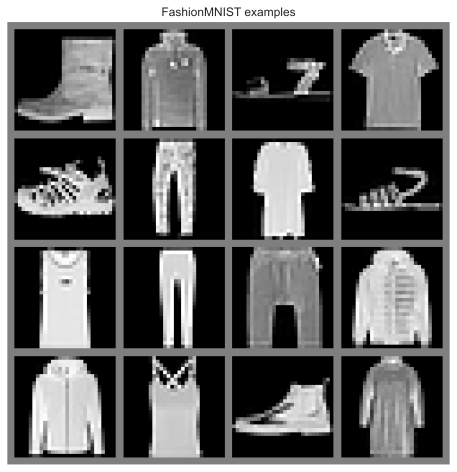

In [10]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.from_numpy(np.stack(exmp_imgs, axis=0))[:,None],
                                       nrow=4,
                                       normalize=True,
                                       pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Visualizing the gradient flow after initialization

As mentioned previously, one important aspect of activation functions is how they propagate gradients through the network. Imagine we have a very deep neural network with more than 50 layers. The gradients for the input layer, i.e. the very first layer, have passed >50 times the activation function, but we still want them to be of a reasonable size. If the gradient through the activation function is (in expectation) considerably smaller than 1, our gradients will vanish until they reach the input layer. If the gradient through the activation function is larger than 1, the gradients exponentially increase and might explode.

To get a feeling of how every activation function influences the gradients, we can look at a freshly initialized network and measure the gradients for each parameter for a batch of 256 images:

In [11]:
small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, collate_fn=numpy_collate)
exmp_batch = next(iter(small_loader))

In [13]:
def visualize_gradients(net, params, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    # Pass one batch through the network, and calculate the gradients for the weights
    def loss_func(p):
        imgs, labels = exmp_batch
        logits = net.apply(p, imgs)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        return loss
    grads = jax.grad(loss_func)(params)
    grads = jax.device_get(grads)
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = jax.tree_util.tree_leaves(grads)
    grads = [g.reshape(-1) for g in grads if len(g.shape) > 1]

    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for g_idx, g in enumerate(grads):
        key = f'Layer {g_idx * 2} - weights'
        key_ax = ax[g_idx%columns]
        sns.histplot(data=g, bins=30, ax=key_ax, color=color, kde=True)
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.act_fn.__class__.__name__}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    plt.close()

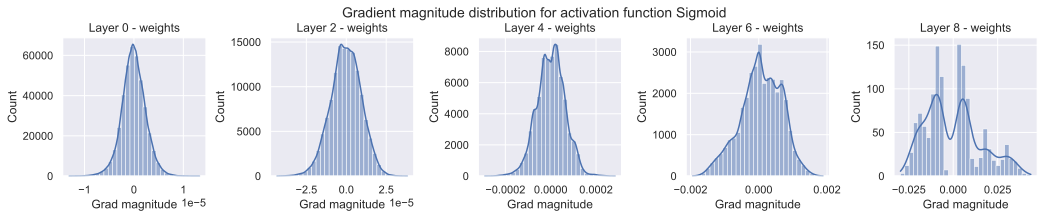

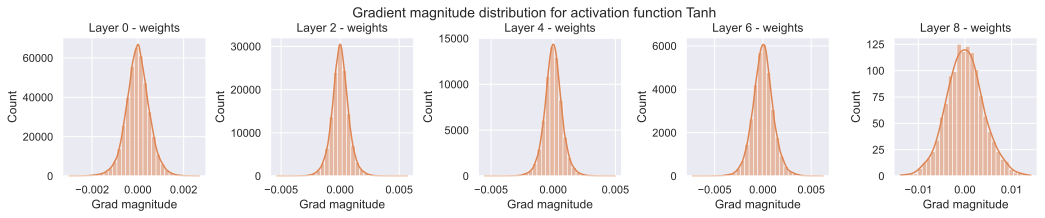

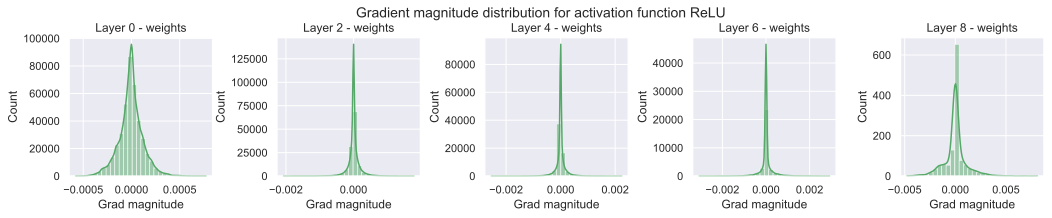

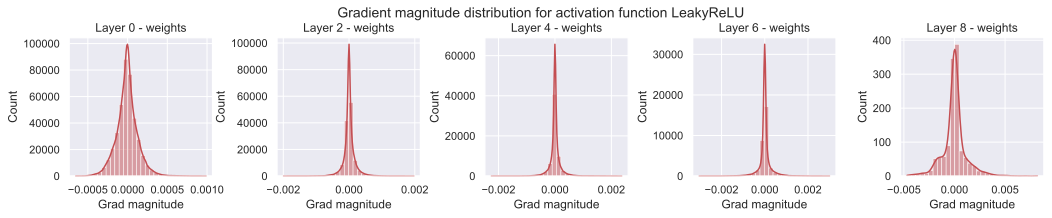

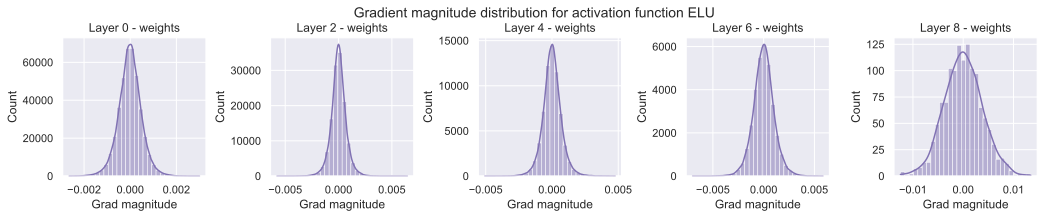

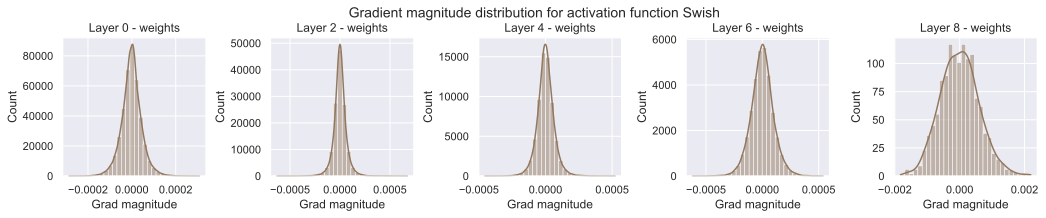

In [16]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    params = net_actfn.init(random.PRNGKey(0), exmp_batch[0])
    visualize_gradients(net_actfn, params, color=f"C{i}")

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with up to 0.1, the input layer has the lowest gradient norm across all activation functions with only 1e-5. This is due to its small maximum gradient of 1/4, and finding a suitable learning rate across all layers is not possible in this setup.
All the other activation functions show to have similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0 which is caused by its zero-part on the left, and dead neurons (we will take a closer look at this later on).

Note that additionally to the activation, the initialization of the weight parameters can be crucial. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialization for linear layers optimized for ReLU activations. In [Tutorial 4](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial4/Optimization_and_Initialization.html), we will take a closer look at initialization, but assume for now that the Kaiming initialization works for all activation functions reasonably well.

### Training a model

Next, we want to train our model with different activation functions on FashionMNIST and compare the gained performance. All in all, our final goal is to achieve the best possible performance on a dataset of our choice.
First, let's write the training and evaluation step that we can compile just-in-time (`jax.jit`) for efficiency:

In [17]:
def calculate_loss(params, apply_fn, batch):
    imgs, labels = batch
    logits = apply_fn(params, imgs)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
    acc = (labels == logits.argmax(axis=-1)).mean()
    return loss, acc

@jax.jit
def train_step(state, batch):
    grad_fn = jax.value_and_grad(calculate_loss,
                                 has_aux=True)
    (_, acc), grads = grad_fn(state.params, state.apply_fn, batch)
    state = state.apply_gradients(grads=grads)
    return state, acc

@jax.jit
def eval_step(state, batch):
    _, acc = calculate_loss(state.params, state.apply_fn, batch)
    return acc

Using these functions, we write a training loop in the next cell including a validation after every epoch and a final test on the best model:

In [18]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        state = None
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Initializing parameters and training state
        params = net.init(random.PRNGKey(42), exmp_batch[0])
        state = train_state.TrainState.create(apply_fn=net.apply,
                                              params=params,
                                              tx=optax.sgd(learning_rate=1e-2,
                                                           momentum=0.9))

        # Defining data loader
        train_loader_local = data.DataLoader(train_set,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             drop_last=True,
                                             collate_fn=numpy_collate,
                                             generator=torch.Generator().manual_seed(42))

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            train_acc = 0.
            for batch in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                state, acc = train_step(state, batch)
                train_acc += acc
            train_acc /= len(train_loader_local)

            ##############
            # Validation #
            ##############
            val_acc = test_model(state, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc:05.2%}, Validation accuracy: {val_acc:4.2%}")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, state.params, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()

    state, _ = load_model(CHECKPOINT_PATH, model_name, state=state)
    test_acc = test_model(state, test_loader)
    print((f" Test accuracy: {test_acc:4.2%} ").center(50, "=")+"\n")
    return state, test_acc


def test_model(state, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        state - Training state including parameters and model apply function.
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    true_preds, count = 0., 0
    for batch in data_loader:
        acc = eval_step(state, batch)
        batch_size = batch[0].shape[0]
        true_preds += acc * batch_size
        count += batch_size
    test_acc = true_preds / count
    return test_acc

We train one model for each activation function. We recommend using the pretrained models to save time if you are running this notebook on CPU.

In [21]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=False)

Training BaseNetwork with sigmoid activation...
Model file already exists. Skipping training...
============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.57% ==============

Training BaseNetwork with relu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.65% ==============

Training BaseNetwork with leakyrelu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.34% ==============

Training BaseNetwork with elu activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.32% ==============

Training BaseNetwork with swish activation...
Model file already exists. Skipping training...
============= Test accuracy: 88.33% ==============



Surprisingly, in contrast to the [PyTorch implementation](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html), the model using the sigmoid activation function actually trains. However, when looking at the validation curve, one can see that the model stays at random performance for many epochs, before it slowly starts learning. The different learning behavior can therefore be explained by small differences in, e.g., initialization or sampled batches.

All the other activation functions gain similar performance to each other and the [PyTorch implementation](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html).
To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages.
However, the "optimal" activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, initialization, etc.) so that a thorough grid search would not be useful in our case.
In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions we experiment with here, with small gains for specific activation functions in specific networks.

### Visualizing the activation distribution

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh?
To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [22]:
def visualize_activations(net, color="C0"):
    activations = {}

    imgs, labels = exmp_batch
    _, activations = net(imgs, return_activations=True)

    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    act_fn_name = net.act_fn.__class__.__name__
    for idx, activ in enumerate(activations):
        key_ax = ax[idx//columns][idx%columns]
        sns.histplot(data=activ.reshape(-1), bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {idx} - {'Dense' if idx%2==0 else act_fn_name}")
    fig.suptitle(f"Activation distribution for activation function {act_fn_name}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close()

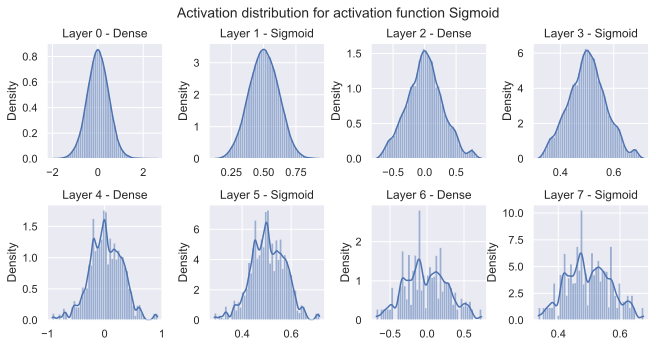

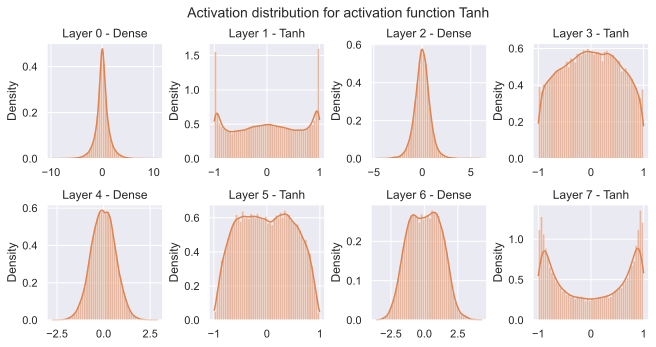

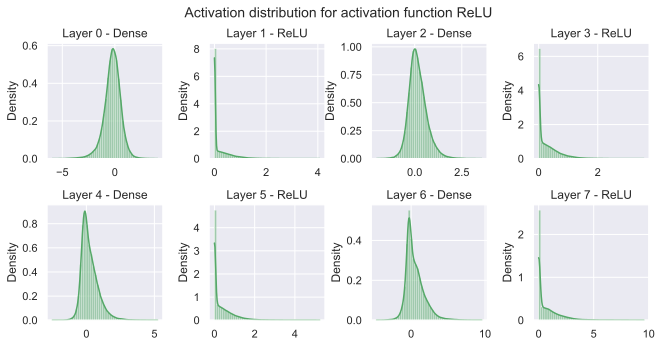

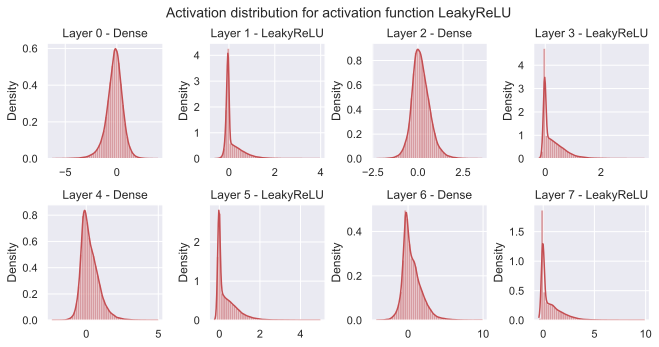

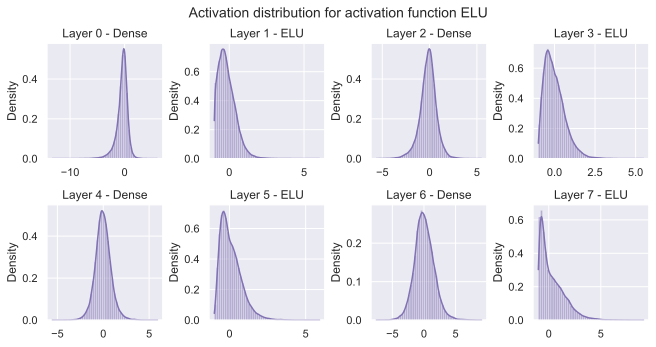

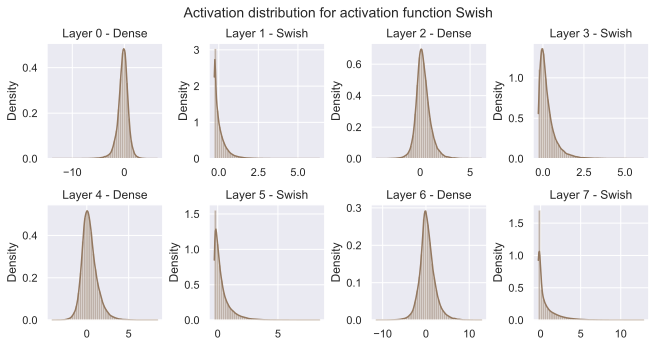

In [23]:
for i, act_fn_name in enumerate(act_fn_by_name):
    state, net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}")
    net_actfn = net_actfn.bind(state.params)
    visualize_activations(net_actfn, color=f"C{i}")

For the model with sigmoid activation, we see a very high peak for the values 0 and 1 in the last layer. This suggests that the model is close to the saturation bounds, in which gradients do not properly flow back. Further, this is also the effect of the inconsistent gradient magnitudes we have seen before: since the layer closest to the output had the highest gradients, we see it is much stronger converged than, e.g., the second layer.

The tanh shows a more diverse behavior overall. While for the input layer we experience a larger amount of neurons to be close to -1 and 1, where the gradients are close to zero, the activations in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).

The ReLU has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but a longer tail towards the positive values.
The LeakyReLU shows a very similar behavior while ELU follows again a more Gaussian-like distribution.
The Swish activation seems to lie in between, although it is worth noting that Swish uses significantly higher values than other activation functions (up to 15).

As all activation functions show slightly different behavior although obtaining similar performance for our simple network, it becomes apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.

### Finding dead neurons in ReLU networks

One known drawback of the ReLU activation is the occurrence of "dead neurons", i.e. neurons with no gradient for any training input.
The issue of dead neurons is that as no gradient is provided for the layer, we cannot train the parameters of this neuron in the previous layer to obtain output values besides zero.
For dead neurons to happen, the output value of a specific neuron of the linear layer before the ReLU has to be negative for all input images.
Considering the large number of neurons we have in a neural network, it is not unlikely for this to happen.

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. For this, we implement a function which runs the network on the whole training set and records whether a neuron is exactly 0 for all data points or not:

In [ ]:
def measure_number_dead_neurons(net, params):
    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        jnp.ones(hd, dtype=jnp.dtype('bool')) for hd in net.hidden_sizes
    ] # Same shapes as hidden size in BaseNetwork

    get_activations = jax.jit(lambda inp: net.apply(params, inp, return_activations=True)[1])
    for imgs, _ in tqdm(train_loader, leave=False): # Run through whole training set
        activations = get_activations(imgs)
        for layer_index, activ in enumerate(activations[1::2]):
            # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
            neurons_dead[layer_index] = jnp.logical_and(neurons_dead[layer_index], (activ == 0).all(axis=0))
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{num_dead / tens.shape[0]:4.2%}" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

First, we can measure the number of dead neurons for an untrained network:

In [ ]:
net_relu = BaseNetwork(act_fn=ReLU())
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

We see that only a minor amount of neurons are dead, but that they increase with the depth of the layer.
However, this is not a problem for the small number of dead neurons we have as the input to later layers is changed due to updates to the weights of previous layers. Therefore, dead neurons in later layers can potentially become "alive"/active again.

How does this look like for a trained network (with the same initialization)?

In [ ]:
state, net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu")
measure_number_dead_neurons(net_relu, state.params)

The number of dead neurons indeed decreased in the later layers. However, it should be noted that dead neurons are especially problematic in the input layer. As the input does not change over epochs (the training set is kept as it is), training the network cannot turn those neurons back active. Still, the input data has usually a sufficiently high standard deviation to reduce the risk of dead neurons.

Finally, we check how the number of dead neurons behaves with increasing layer depth. For instance, let's take the following 10-layer neural network:

In [ ]:
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128])
params = net_relu.init(random.PRNGKey(42), exmp_batch[0])
measure_number_dead_neurons(net_relu, params)

The number of dead neurons is significantly higher than before which harms the gradient flow especially in the first iterations. For instance, more than 50% of the neurons in the last layers are dead which creates a considerable bottleneck.
Hence, it is advisible to use other nonlinearities like Swish for very deep networks.

## Conclusion

In this notebook, we have reviewed a set of six activation functions (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish) in neural networks, and discussed how they influence the gradient distribution across layers. Sigmoid tends to fail in deep neural networks as the highest gradient it provides is 0.25 leading to vanishing gradients in early layers. All ReLU-based activation functions have shown to perform well, and besides the original ReLU, do not have the issue of dead neurons. When implementing your own neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.

## References

[1] Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017). [Paper link](https://arxiv.org/abs/1710.05941)

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub.

---